In [5]:
import pandas as pd
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.reparam.transform import TransformReparam
from pyro.infer.reparam import LocScaleReparam
import torch
from torch.special import expit
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split




In [2]:
# some comments
pyro.set_rng_seed(101)

In [3]:
%matplotlib inline

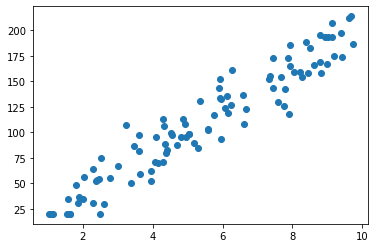

In [4]:
# Generate items
# For now, items described by single attribute - quality
# Each item has a list price determined by that quality
num_items = torch.tensor(100)
item_quality = torch.distributions.Uniform(1, 10).sample([num_items])
#pyro.sample("item_quality", pyro.distributions.Uniform(1, 10).expand([num_items,]))
list_price = torch.maximum(torch.distributions.Normal(item_quality, torch.tensor(1.0)).sample(),torch.tensor(1.0)) * 20
plt.scatter(item_quality, list_price)
mean_quality = torch.mean(item_quality)
mean_list_price = torch.mean(list_price)

torch.Size([1852]) torch.Size([1852])


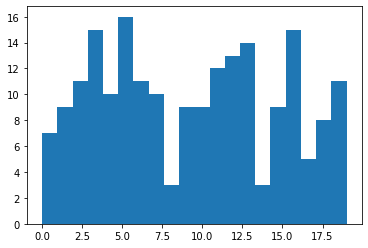

In [6]:
# Generate customers
# Each customer has a view on the value of item quality which determines their willingness to pay
num_cust = torch.tensor(200)
beta_quality_loc = torch.log(pyro.sample("beta_quality_loc", pyro.distributions.Uniform(5,10)))
beta_quality_scale = torch.log(pyro.sample("beta_quality_scale", pyro.distributions.Uniform(1,2)))
beta_quality = pyro.sample("beta_quality", pyro.distributions.LogNormal(beta_quality_loc, beta_quality_scale).expand([num_cust,]))
mean_beta_quality = torch.mean(beta_quality)
std_beta_quality = torch.std(beta_quality)

# Generate salespeople
# Each salesperson has an ability to estimate the customers wtp subject to some bias and uncertainty
num_sales = torch.tensor(20)
sales_wtp_bias = pyro.sample("sales_wtp_bias", pyro.distributions.Uniform(-0.2,0.1).expand([num_sales,]))
sales_wtp_uncertainty = pyro.sample("sales_wtp_uncertainty", pyro.distributions.Uniform(0.1,0.5).expand([num_sales,]))

# Generate quotes
## Each customer generates a number of quotes for items
## Salespeople ramdomly assigned to quotes
# Either won with price recorded or lost with price not recorded
max_items_per_customer = 20
concentration = torch.tensor(5.0).repeat(max_items_per_customer)
item_probs = torch.distributions.Dirichlet(concentration).sample()
num_item_by_cust = torch.distributions.Categorical(item_probs).sample([num_cust,])
plt.hist(num_item_by_cust.numpy(), bins=max_items_per_customer)

customer_id_list = []
customer_items_list = []
for customer, num_items_for_cust in enumerate(num_item_by_cust):
    customer_id_inc = [customer] * num_items_for_cust
    customer_items_inc = torch.randperm(num_items)[:num_items_for_cust].tolist()
    customer_id_list.extend(customer_id_inc)
    customer_items_list.extend(customer_items_inc)
    
customer_id = torch.tensor(customer_id_list, dtype=torch.int64)
customer_items = torch.tensor(customer_items_list, dtype=torch.int64)
print(customer_id.shape, customer_items.shape)

num_quotes = customer_items.shape[0]

outcome = {}
for q in range(num_quotes):
    c = customer_id[q]
    s = random.randrange(num_sales)
    i = customer_items[q]
    wtp = torch.minimum(item_quality[i] * beta_quality[c], list_price[i])
    est_wtp = torch.minimum(pyro.sample("estimated_wtp", pyro.distributions.Normal(wtp, wtp*sales_wtp_uncertainty[s])), list_price[i])
    #est_wtp = pyro.sample("estimated_wtp", pyro.distributions.Normal(wtp*(1+sales_wtp_bias[s]), wtp*sales_wtp_uncertainty[s]))
    if wtp.item() >= list_price[i].item():
        result = 1
        price = list_price[i].item()
    if wtp.item() < est_wtp.item():
        result = 0
        price = np.nan
    else:
        result = 1
        price = ( est_wtp.item() + wtp.item() ) /2
    outcome[q] = {'customer':c.item(), 'item':i.item(), 'result':result, 'price':price, 'list_price':list_price[i].item(), 'wtp':wtp.item(), 'est_wtp':est_wtp.item(), 'salesperson':s, 'item_quality':item_quality[i].item()}



In [7]:
df = pd.DataFrame.from_dict(outcome, orient='index')

In [8]:
df.sample(10)

,customer,item,result,price,list_price,wtp,est_wtp,salesperson,item_quality
862,98,11,1,17.448937,20.000000,20.000000,14.897875,15,1.644644
1613,173,89,0,NaN,159.455078,46.936981,56.099541,16,8.034837
1532,167,14,0,NaN,173.286423,146.249207,173.286423,7,7.884535
926,103,72,1,28.687814,89.354507,28.833904,28.541723,2,5.189973
1120,127,13,1,80.475105,125.588455,85.115585,75.834625,17,7.768985
1145,128,20,0,NaN,193.206909,39.994987,41.882351,2,8.940372
44,4,69,1,9.718314,95.136833,13.565639,5.870988,12,4.824830
845,95,71,1,54.260769,88.765862,55.536259,52.985279,11,4.342316
1115,125,27,1,23.460319,36.854252,27.050220,19.870417,8,1.892911
0,0,68,1,23.950771,173.554260,24.921417,22.980125,18,9.427942


In [9]:
df.describe()

,customer,item,result,price,list_price,wtp,est_wtp,salesperson,item_quality
count,1852.000000,1852.000000,1852.000000,963.000000,1852.000000,1852.000000,1852.000000,1852.000000,1852.000000
mean,101.410907,50.192765,0.519978,46.877903,109.796813,50.935136,49.706307,9.415227,5.426437
std,57.871961,28.971606,0.499736,35.860882,54.347384,35.226267,37.637233,5.669623,2.508157
min,0.000000,0.000000,0.000000,3.084616,20.000000,3.504327,-16.404335,0.000000,1.027092
25%,52.000000,26.000000,0.000000,20.841639,64.158623,24.220191,21.490487,4.000000,3.462948
50%,103.000000,50.000000,1.000000,37.491516,107.543877,43.288094,40.432938,9.000000,5.298374
75%,152.000000,76.000000,1.000000,60.000746,155.444672,67.755705,67.248335,14.000000,7.794953
max,199.000000,99.000000,1.000000,211.641022,213.749908,213.749908,209.532135,19.000000,9.727151


<AxesSubplot:ylabel='Frequency'>

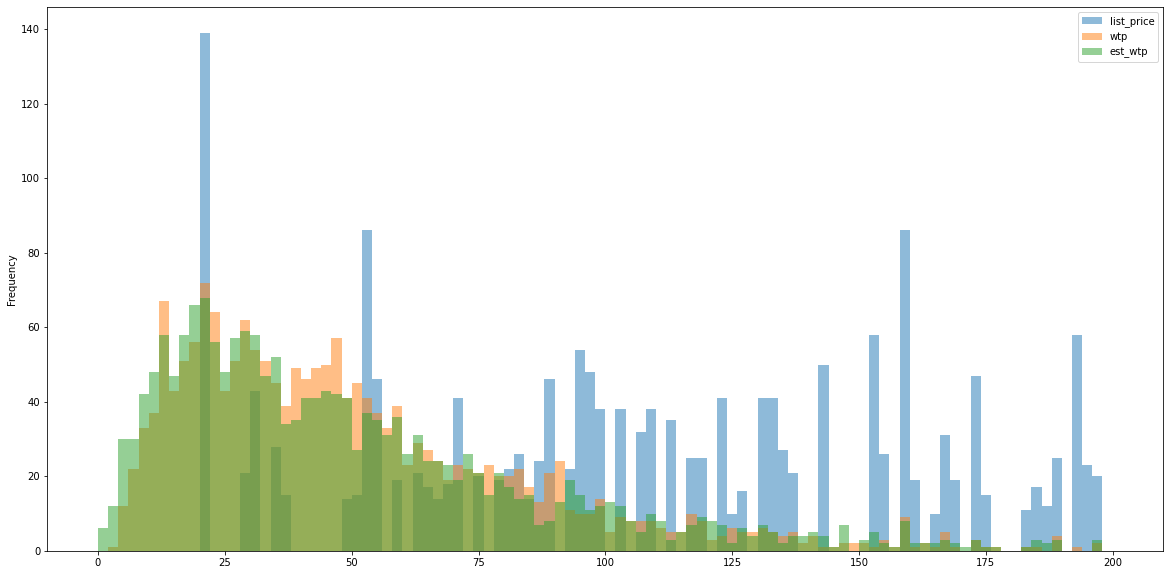

In [10]:
# Distribution of price-like variables
df[['list_price', 'wtp', 'est_wtp']].plot.hist(bins=100, alpha=0.5, figsize=(20,10), range=(0,200))

<AxesSubplot:xlabel='index', ylabel='price'>

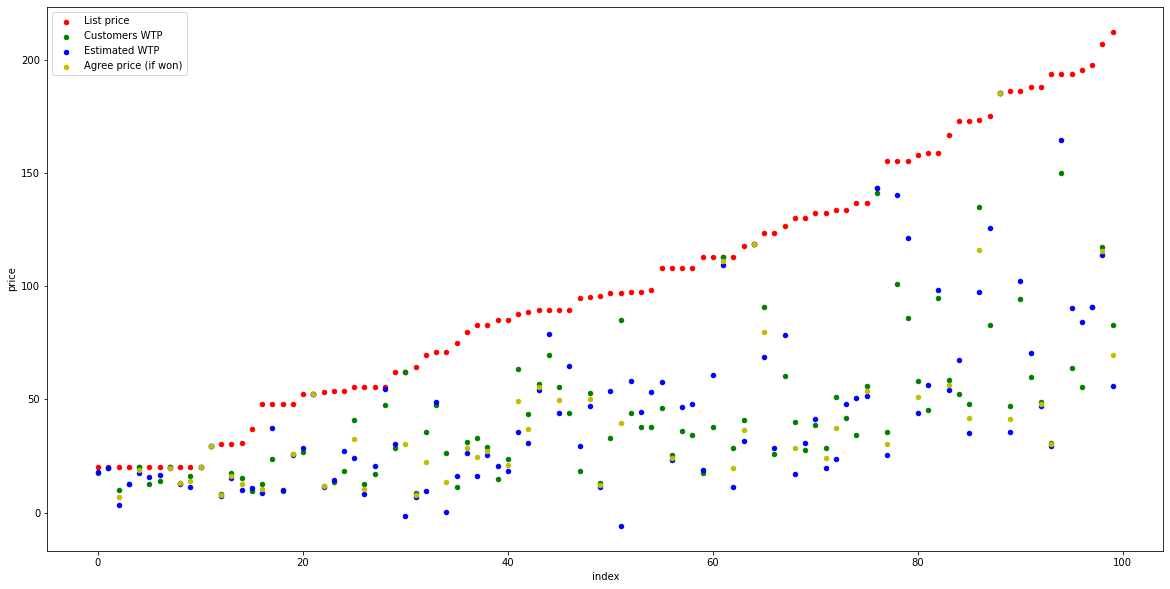

In [11]:
examples = df.sample(100).sort_values(by='list_price').reset_index(drop=True).reset_index()
ax = examples.plot.scatter(x='index', y='list_price', color='r', label='List price', figsize=(20,10))
examples.plot.scatter(x='index', y='wtp', color='g', label='Customers WTP', ax=ax)
examples.plot.scatter(x='index', y='est_wtp', color='b', label='Estimated WTP', ax=ax)
examples.plot.scatter(x='index', y='price', color='y', label='Agree price (if won)', ax=ax)

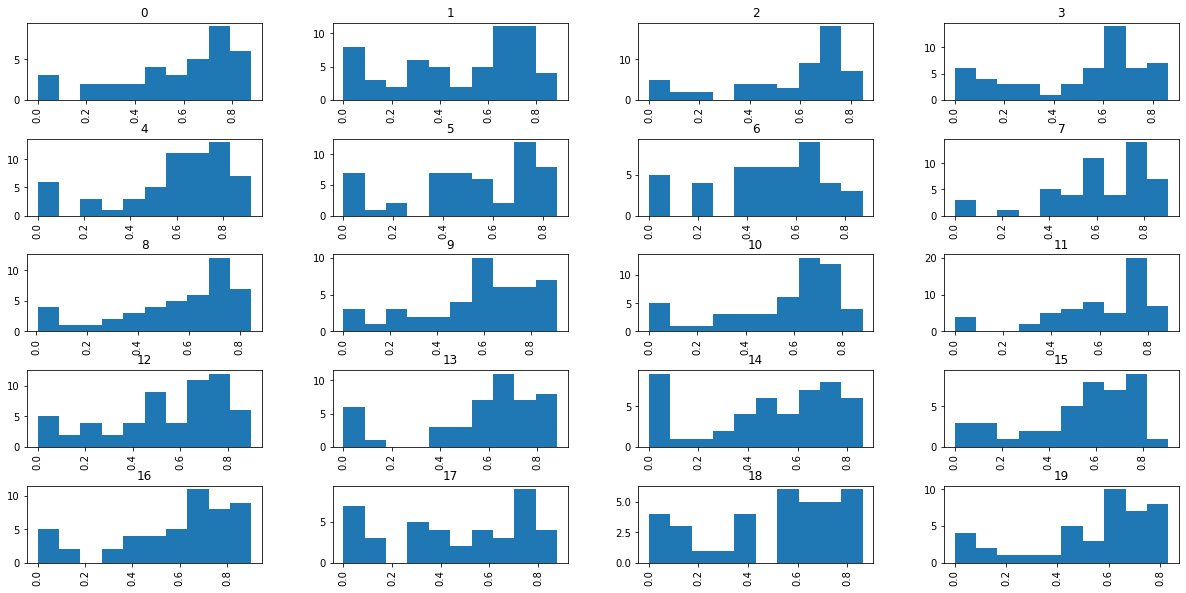

In [12]:
# Distribution of discounts on won deals by salesperson
df['discount'] = np.where(df['result']==1, 1 - df['price']/df['list_price'], np.nan)
_ = df['discount'].hist(by=df['salesperson'], figsize=(20,10))
#plt.show()

In [198]:
# compare salespeople:
    # num quotes
    # bias
    # uncertainty
    # avg discount on won deals
    # % of quotes won
    # potential revenue
    # actual revenue
    # % potential won

ss = df.reset_index().groupby('salesperson').agg({'index':'count', 'discount':'mean', 'result':'mean', 'wtp':'sum', 'price':'sum'})

In [153]:
ss['wtp_bias'] = sales_wtp_bias
ss['wtp_uncertainty'] = sales_wtp_uncertainty
ss['pct_wtp_captured'] = ss['price']/ss['wtp']

In [23]:
ss.to_csv('ss.csv')

Best number of neighbours: {'n_neighbors': 15}


C:\Users\paul_\neg-price-model\envs\neg-price-env\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\paul_\neg-price-model\envs\neg-price-env\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\paul_\neg-price-model\envs\neg-price-env\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\paul_\neg-price-model\envs\neg-price-env\lib\site-packages\sklearn\base.py", line 700, in score
    y_pred = self.predict(X)
  File "C:\Users\paul_\neg-price-model\envs\neg-price-env\lib\site-packages\sklearn\neighbors\_regression.py", line 229, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\paul_\neg-price-model\envs\neg

Text(0, 0.5, 'wtp_uncertainty')

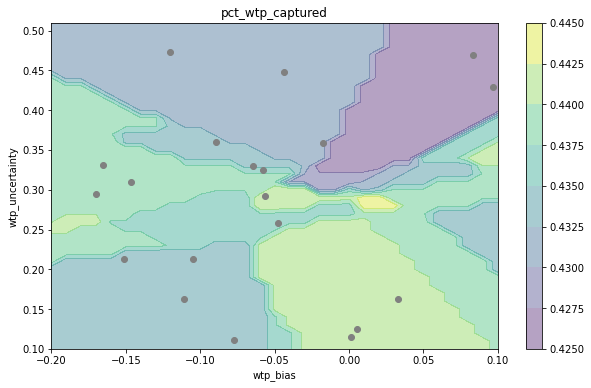

In [154]:
# Get data into numpy arrays
X=ss[['wtp_bias','wtp_uncertainty']].values
y=ss['pct_wtp_captured'].values.reshape(-1, 1)

# Train knn model
num_neigh = np.arange(5, 150, 10)
hyperparameters = dict(n_neighbors=num_neigh)
knr = KNeighborsRegressor()
tune_neigh = GridSearchCV(knr, hyperparameters, cv=10)
neigh = tune_neigh.fit(X,y)
print('Best number of neighbours: ' + str(tune_neigh.best_params_))

# Predict field over range of x1, x2
x1_values = np.arange(-0.2, 0.1, 0.01)
x2_values = np.arange(0.1, 0.52, 0.01)
xx1, xx2 = np.meshgrid(x1_values, x2_values)
X_pred = np.array([xx1.ravel(), xx2.ravel()]).T
z = neigh.predict(X_pred)

# Plot field and also show where individual points are
fig, ax = plt.subplots(figsize=(10,6))
cf = ax.contourf(xx1, xx2, z.reshape(xx1.shape), alpha = 0.4)#, norm=norm)
fig.colorbar(cf, ax=ax)
ax.scatter(x=X[:,0], y=X[:,1], c='grey')
ax.set_title('pct_wtp_captured')
ax.set_xlabel('wtp_bias')
ax.set_ylabel('wtp_uncertainty')

<AxesSubplot:xlabel='discount', ylabel='result'>

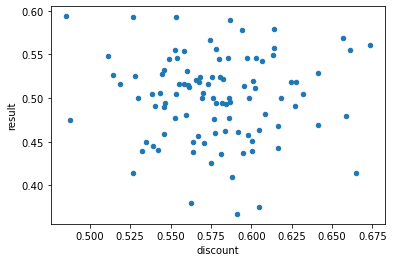

In [15]:
# relationship between discount and conversion
ss.plot.scatter(x='discount', y='result')

<AxesSubplot:xlabel='discount', ylabel='pct_wtp_captured'>

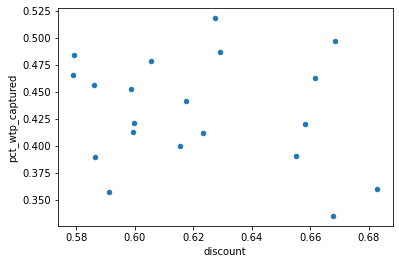

In [155]:
# relationship between discount and pct wtp captured
ss.plot.scatter(x='discount', y='pct_wtp_captured')

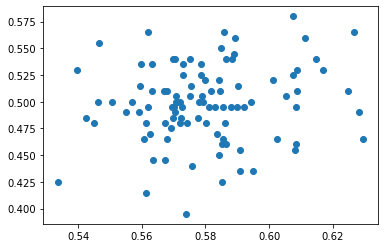

In [17]:
# randomly sample from data - check for any correlation between discount and conversion
rng = np.random.default_rng()
idx = rng.choice(len(df), (200,100))
res = []
for i in range(idx.shape[1]):
    s = df.iloc[idx[:,i]]
    m = s[['discount', 'result']].mean().values
    res.append(m)
resa = np.array(res)
plt.scatter(x=resa[:,0], y=resa[:,1])

<AxesSubplot:xlabel='discount', ylabel='result'>

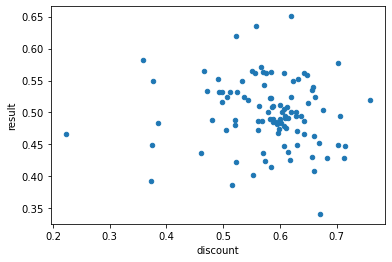

In [18]:
ii = df.reset_index().groupby('item').agg({'index':'count', 'discount':'mean', 'result':'mean', 'wtp':'sum', 'price':'sum'})
ii.plot.scatter(x='discount', y='result')

In [13]:
# map customer, item and salesperson ids to sequential versions of same for convenience later
customer_map = {}
for i, c in enumerate(df['customer'].unique()):
    customer_map[c] = i
item_map = {}
for i, item in enumerate(df['item'].unique()):
    item_map[item] = i
salesperson_map = {}
for i, s in enumerate(df['salesperson'].unique()):
    salesperson_map[s] = i

df['customer'] = df['customer'].map(customer_map)
df['item'] = df['item'].map(item_map)
df['salesperson'] = df['salesperson'].map(salesperson_map)

In [14]:
X = df[['customer', 'item',	'list_price', 'salesperson', 'item_quality']]
y = df[['result', 'price']]

In [15]:
X['customer'].max()

192

In [49]:
def model(X, y=None):

    x_salesperson = torch.tensor(X['salesperson'].values)
    x_item_quality = torch.tensor(X['item_quality'].values)
    x_list_price = torch.tensor(X['list_price'].values)
    x_customer = torch.tensor(X['customer'].values)

    if y is not None:
        y_result = torch.tensor(y['result'].values, dtype=torch.double)
        y_price = torch.tensor(y['price'].values)
    
    # Salespeople
    num_sales = X['salesperson'].nunique() # number of salespeople in data
    # prior on bias in salespersons estimate of customers wtp, a proportion of the wtp
    sales_wtp_bias_mean = pyro.sample(
        "sales_wtp_bias_pct_mean",
        dist.Normal(-0.1,0.2)
    )
    sales_wtp_bias_sigma = pyro.sample(
        "sales_wtp_bias_pct_sigma",
        dist.HalfNormal(0.2)
    )
    # a prior on the error on the salespersons estimate of the customers wtp, a proportion of the wtp
    sales_wtp_uncertainty_scale = pyro.sample(
        "sales_wtp_uncertainty_pct_scale",
        dist.HalfNormal(torch.tensor(0.2))
    )
    # sample salespeople
    with pyro.plate('salespeople', num_sales): 
        with pyro.poutine.reparam(config={"sales_wtp_bias_pct": TransformReparam()}):
            sales_wtp_bias = pyro.sample(
                "sales_wtp_bias_pct",
                dist.TransformedDistribution(
                    dist.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).expand([num_sales,]),
                    dist.transforms.AffineTransform(sales_wtp_bias_mean, sales_wtp_bias_sigma),
                ),
            )
        sales_wtp_uncertainty = pyro.sample("sales_wtp_uncertainty_pct", dist.HalfNormal(scale=sales_wtp_uncertainty_scale))
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": TransformReparam()}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.TransformedDistribution(
        #             dist.HalfNormal(scale=torch.ones((num_sales,))),
        #             dist.transforms.AffineTransform(0.0, sales_wtp_uncertainty_scale),
        #         ),
        #     )
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": LocScaleReparam()}):#centered=0)}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.LogNormal(loc=0.0, scale=sales_wtp_uncertainty_scale).expand([num_sales,])
        #     )
    #print(sales_wtp_uncertainty_scale)
    #print(sales_wtp_uncertainty)


    #print('salespeople shapes: ', sales_wtp_bias.shape, sales_wtp_uncertainty.shape)

    # Customers
    num_cust= X['customer'].nunique()
    #num_cust = len(X) # number of customers (and rows) in data
    #print(num_cust)
    #prior_beta_quality_loc = pyro.distributions.Uniform(5,10) # prior of the mean of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    #prior_beta_quality_scale = pyro.distributions.Uniform(1,2) # prior of the std deviation of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    beta_quality_loc = pyro.sample("beta_quality_loc", 
            dist.TransformedDistribution(
                dist.Uniform(5,15),
                dist.transforms.ExpTransform().inv
            )
    ) # sample mean betas from prior distribution
    beta_quality_scale = pyro.sample("beta_quality_scale", 
        dist.InverseGamma(1, 1)
    )
    #print(beta_quality_loc, beta_quality_scale)
     # # sample std deviation of beta from prior distribution
    #print(beta_quality_loc, beta_quality_scale)
    #beta_quality = torch.distributions.LogNormal(beta_quality_loc, beta_quality_scale).sample([num_cust,])
    #print(beta_quality.shape)


    with pyro.plate('customers', num_cust): #sample customers, all from same distribution for now
    #     with pyro.poutine.reparam(config={"beta_quality": TransformReparam()}):
    #         beta_quality = pyro.sample(
    #             "beta_quality",
    #             dist.TransformedDistribution(
    #                 dist.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).expand([num_cust,]),
    #                 dist.transforms.AffineTransform(beta_quality_loc, beta_quality_scale),
    #             ),
    #         )

        # with pyro.poutine.reparam(config={"beta_quality": LocScaleReparam()}):#centered=0)}):
        #     beta_quality = pyro.sample(
        #         "beta_quality",
        #         dist.LogNormal(loc=beta_quality_loc, scale=beta_quality_scale).expand([num_cust,])
        #     )

        beta_quality = pyro.sample("beta_quality", pyro.distributions.LogNormal(beta_quality_loc, beta_quality_scale).expand([num_cust,]))

    #print('customer params shape: ', beta_quality.shape)
    #print(x_item_quality.shape, beta_quality.shape, x_customer.shape, x_list_price.shape)
    #wtp = pyro.deterministic("wtp", torch.clamp(x_item_quality * beta_quality[x_customer], min=torch.ones_like(x_list_price), max=x_list_price))
    wtp_unbound = x_item_quality * beta_quality[x_customer]
    wtp = torch.nn.functional.softplus(wtp_unbound)
    #print(wtp.shape, sales_wtp_uncertainty.shape, x_salesperson.shape)
    wtp_uncertainty = wtp * sales_wtp_uncertainty[x_salesperson]
    #print('wtp shapes: ', wtp.shape, wtp_uncertainty.shape)
    #print('shape of x_list_price:', x_list_price.shape)
    #print(wtp_uncertainty.min(), wtp.min(), sales_wtp_uncertainty[x_salesperson].min())
    #print(sales_wtp_uncertainty)
    #est_wtp = torch.clamp(
    est_wtp = pyro.sample(
            "estimated_wtp",
            dist.FoldedDistribution(
                pyro.distributions.Normal(wtp, wtp_uncertainty)
            )
        #), 
        #min=torch.ones_like(x_list_price), 
        #max=x_list_price
    )
    #print('shape of est_wtp', est_wtp.shape)
    #prob_win = torch.where(wtp < est_wtp, torch.zeros_like(x_list_price), torch.ones_like(x_list_price))
    prob_win = expit(wtp - est_wtp)

    with pyro.plate('negotiations'):
        
        result = pyro.sample("result", pyro.distributions.Bernoulli(prob_win), obs = None if y is None else y_result)
        #hidden_price = torch.where(wtp < x_list_price, (est_wtp+wtp) /2, x_list_price)
        #if y is not None:
            #mask = y_result == torch.tensor(1)
            #with pyro.poutine.mask(mask = mask):#.type(torch.ByteTensor)):
                #price = pyro.sample("price_if_won", pyro.distributions.Normal(hidden_price, 0.01), obs = y_price)#[mask])#None if y is None else y_price)
                #price = pyro.sample("price_if_won", pyro.distributions.Delta(hidden_price), obs = y_price)#[mask])#None if y is None else y_price)

    #outcome[c] = {'item':i, 'result':result, 'price':hidden_price, 'list_price':list_price[i].item(), 'wtp':wtp.item(), 'est_wtp':est_wtp.item(), 'salesperson':s}

    return result#, hidden_price, None if y is None else price

In [50]:
num_sales = X['salesperson'].nunique()
num_cust = X['customer'].nunique()
num_quotes = len(X)

pyro.clear_param_store()

nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_samples=1000,
    warmup_steps=200
    #,initial_params=({'sales_wtp_bias_pct_mean':torch.tensor(-0.1), 'sales_wtp_bias_pct_sigma':torch.tensor(0.2),'sales_wtp_uncertainty_pct_scale':torch.tensor(0.2)
    #, 'sales_wtp_bias_pct':torch.full((num_sales,),0.0), 'sales_wtp_uncertainty_pct':torch.full((num_sales,),0.1)
    #, 'beta_quality_loc':torch.tensor(7.5), 'beta_quality_scale':torch.tensor(1.5)#, 'beta_quality':torch.full((num_cust,),10.0)
    #, 'estimated_wtp':torch.full((num_quotes,),40.0)  
    #})
    )
with pyro.validation_enabled():
    mcmc.run(X,y)
print(mcmc.summary())



Warmup:  12%|█▏        | 147/1200 [00:25,  9.93it/s, step size=8.80e-02, acc. prob=0.771]

KeyboardInterrupt: 

In [38]:
samples = mcmc.get_samples()
samples.keys()

dict_keys(['beta_quality', 'beta_quality_loc', 'beta_quality_scale', 'estimated_wtp', 'sales_wtp_bias_pct_base', 'sales_wtp_bias_pct_mean', 'sales_wtp_bias_pct_sigma', 'sales_wtp_uncertainty_pct', 'sales_wtp_uncertainty_pct_scale'])

Text(0.5, 1.0, 'beta_quality')

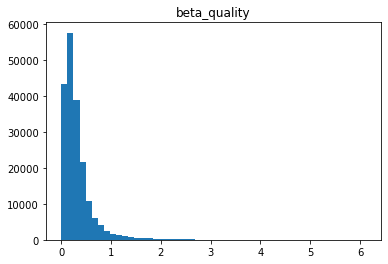

In [39]:
samples['beta_quality'].shape
_ = plt.hist(samples['beta_quality'].view(-1).numpy(), bins=50)
plt.title('beta_quality')

Text(0.5, 1.0, 'estimated_wtp')

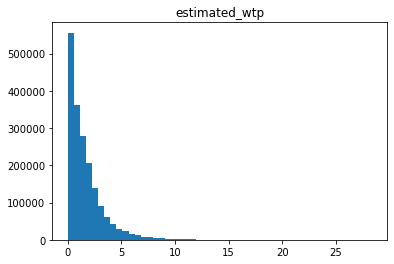

In [40]:
samples['estimated_wtp'].shape
_ = plt.hist(samples['estimated_wtp'].flatten().numpy(), bins=50)
plt.title('estimated_wtp')


Text(0.5, 1.0, 'sales_wtp_uncertainty_pct_scale')

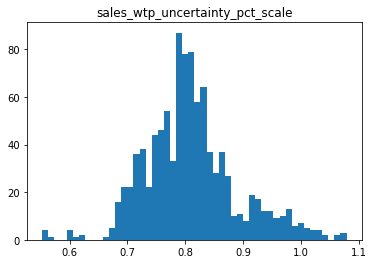

In [41]:
samples['sales_wtp_uncertainty_pct_scale'].shape
_ = plt.hist(samples['sales_wtp_uncertainty_pct_scale'].flatten().numpy(), bins=50)
plt.title('sales_wtp_uncertainty_pct_scale')

Text(0.5, 1.0, 'sales_wtp_uncertainty_pct')

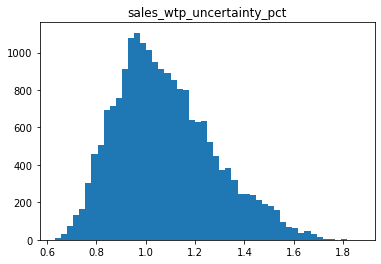

In [42]:
samples['sales_wtp_uncertainty_pct'].shape
_ = plt.hist(samples['sales_wtp_uncertainty_pct'].flatten().numpy(), bins=50)
plt.title('sales_wtp_uncertainty_pct')

Text(0.5, 1.0, 'sales_wtp_bias_pct_base')

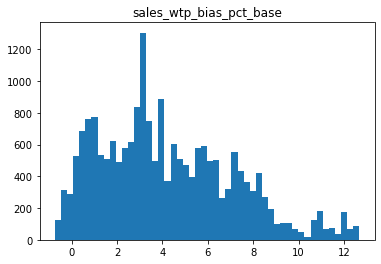

In [43]:

samples['sales_wtp_bias_pct_base'].shape
_ = plt.hist(samples['sales_wtp_bias_pct_base'].flatten().numpy(), bins=50)
plt.title('sales_wtp_bias_pct_base')

20
4


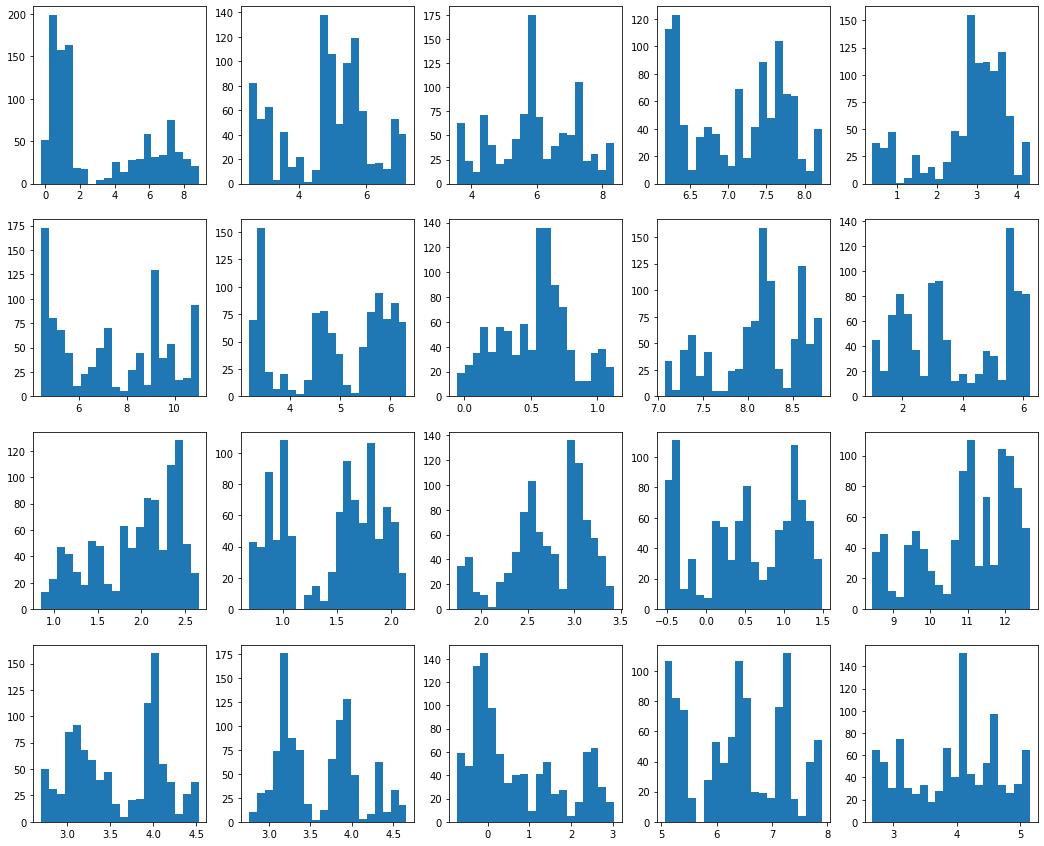

In [44]:
numplots = samples['sales_wtp_bias_pct_base'].shape[-1]
print(numplots)
columns = 5
whole_rows, part_rows = divmod(numplots, columns)
rows = whole_rows + int(part_rows>0)
print(rows)
fig,axs = plt.subplots(rows,columns, figsize=(18,15))

for i, ax in enumerate(axs.ravel()):
    if i < numplots:
        ax.hist(samples['sales_wtp_bias_pct_base'][:,i].numpy(), bins = 20)

In [28]:
sales_wtp_bias

tensor([-0.0835,  0.0162, -0.1091, -0.0687, -0.0385, -0.1221, -0.0950, -0.1899,
         0.0709, -0.0189,  0.0518, -0.0721,  0.0925, -0.1876,  0.0334,  0.0269,
        -0.1719, -0.1511,  0.0778, -0.0979])

In [228]:
x = torch.tensor([1, 2, 3, 4, 5])
y = torch.tensor([5, 4, 3, 2, 1])

z = torch.where(x > y, torch.zeros_like(x), torch.ones_like(x))
z

tensor([1, 1, 1, 0, 0])

tensor(1.8351) tensor(2.0601)


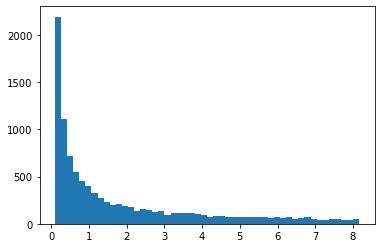

In [107]:
xyz = pyro.sample(
        "xyz",
        dist.TransformedDistribution(
            dist.Uniform(-2.3,2.1).expand([10000,]),
            dist.transforms.ExpTransform()
        )
    )
_ = plt.hist(xyz.numpy(), bins=50)
print(xyz.mean(), xyz.std())

Warmup:   0%|          | 0/30 [06:26, ?it/s]


tensor(-0.2268) tensor(1.1071)


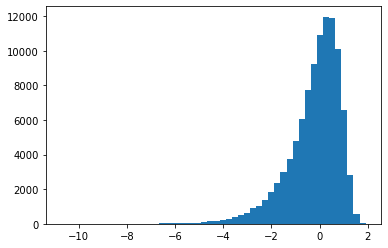

In [128]:
xyz = pyro.sample(
        "xyz",
        dist.TransformedDistribution(
            dist.HalfNormal(1.5).expand([100000,]),
            dist.transforms.ExpTransform().inv
        )
    )
_ = plt.hist(xyz.numpy(), bins=50)
print(xyz.mean(), xyz.std())

tensor(7.9443) tensor(50.2723)


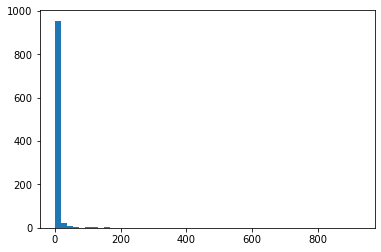

In [145]:
alpha = 1
beta = 1
#print('mean: ',beta / (alpha-1))
xyz = pyro.sample(
        "xyz",
        dist.InverseGamma(alpha, beta).expand([1000,]),
    )
_ = plt.hist(xyz.numpy(), bins=50)
print(xyz.mean(), xyz.std())

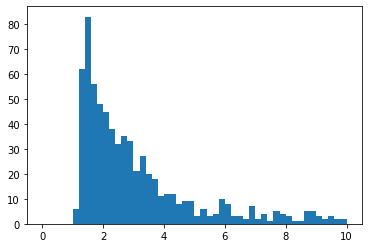

In [146]:
_ = plt.hist(xyz.exp().numpy(), bins=50, range=(0,10))

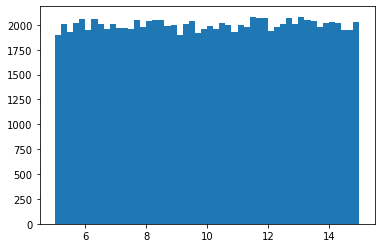

In [112]:
_ = plt.hist(xyz.exp().numpy(), bins=50)

In [105]:
def lognormal_params(mu, sigma):
    loc = np.log(mu**2/np.sqrt(mu**2 + sigma**2))
    scale = np.sqrt(np.log(1 + sigma**2/mu**2))
    return loc, scale

lognormal_params(1, 10)

(-2.30756025842063, 2.148283155648077)

n order to produce a distribution with desired mean
{\displaystyle \mu _{X}}$$ and variance $${\displaystyle \sigma _{X}^{2}}$$, one uses  {\displaystyle \mu =\ln \left({\frac {\mu _{X}^{2}}{\sqrt {\mu _{X}^{2}+\sigma _{X}^{2}}}}\right)}{\displaystyle \mu =\ln \left({\frac {\mu _{X}^{2}}{\sqrt {\mu _{X}^{2}+\sigma _{X}^{2}}}}\right)} and {\displaystyle \sigma ^{2}=\ln \left(1+{\frac {\sigma _{X}^{2}}{\mu _{X}^{2}}}\right).}{\displaystyle \sigma ^{2}=\ln \left(1+{\frac {\sigma _{X}^{2}}{\mu _{X}^{2}}}\right).}


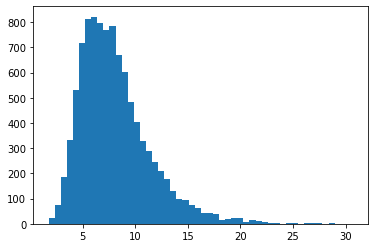

In [89]:
a = torch.tensor(7.5).log()
b = torch.tensor(1.5).log()

pqr = dist.LogNormal(loc=a,scale=b).sample((10000,1))
_ = plt.hist(pqr.numpy(), bins=50)

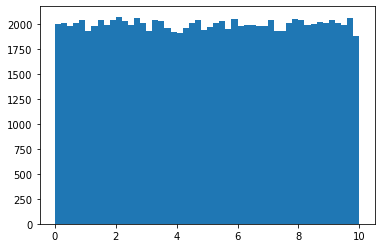

In [92]:
aa = dist.Uniform(0, 10).sample((100000,1))
_ = plt.hist(aa.numpy(), bins=50)

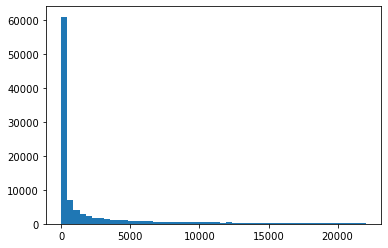

In [94]:
bb = np.exp(aa)
_ = plt.hist(bb.numpy(), bins=50)

Warmup:   0%|          | 0/30 [11:06, ?it/s]


(array([644., 714., 676., 649., 614., 628., 598., 554., 535., 490., 469.,
        413., 383., 333., 286., 245., 276., 217., 208., 183., 158., 124.,
        118.,  99.,  77.,  60.,  55.,  46.,  35.,  27.,  20.,  19.,  14.,
         10.,   3.,   3.,   3.,   2.,   2.,   4.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.]),
 array([2.21840164e-05, 1.71710644e-02, 3.43199447e-02, 5.14688268e-02,
        6.86177090e-02, 8.57665911e-02, 1.02915466e-01, 1.20064348e-01,
        1.37213230e-01, 1.54362112e-01, 1.71510994e-01, 1.88659877e-01,
        2.05808759e-01, 2.22957641e-01, 2.40106508e-01, 2.57255405e-01,
        2.74404287e-01, 2.91553169e-01, 3.08702052e-01, 3.25850904e-01,
        3.42999786e-01, 3.60148668e-01, 3.77297550e-01, 3.94446433e-01,
        4.11595315e-01, 4.28744197e-01, 4.45893079e-01, 4.63041961e-01,
        4.80190843e-01, 4.97339725e-01, 5.14488578e-01, 5.31637490e-01,
        5.48786342e-01, 5.65935254e-01, 5.83084106e-01, 6.00233018e-01,
        6.

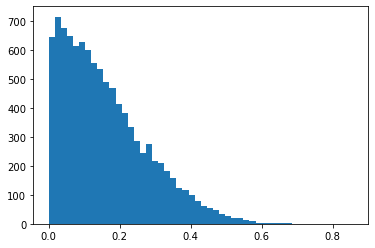

In [37]:
from pyro.infer.reparam.transform import TransformReparam

num_sales = 10000
scale = torch.tensor(0.2)

with pyro.poutine.reparam(config={"zzz": TransformReparam()}):
    zzz = pyro.sample(
        "zzz",
        dist.TransformedDistribution(
            dist.HalfNormal(scale=torch.ones((num_sales,))),
            dist.transforms.AffineTransform(0.0, scale),
        ),
    )
       
plt.hist(zzz.numpy(), bins=50)

(array([133., 137., 142., 156., 158., 184., 216., 241., 250., 305., 341.,
        374., 397., 402., 449., 449., 447., 471., 463., 426., 442., 417.,
        384., 380., 341., 268., 268., 216., 196., 166., 135., 142., 108.,
         92.,  75.,  55.,  42.,  30.,  18.,  15.,  17.,  14.,  13.,  10.,
          5.,   4.,   1.,   2.,   1.,   2.]),
 array([3.7074089e-04, 2.2839700e-01, 4.5642325e-01, 6.8444955e-01,
        9.1247576e-01, 1.1405021e+00, 1.3685284e+00, 1.5965545e+00,
        1.8245808e+00, 2.0526071e+00, 2.2806334e+00, 2.5086596e+00,
        2.7366860e+00, 2.9647121e+00, 3.1927383e+00, 3.4207647e+00,
        3.6487908e+00, 3.8768172e+00, 4.1048436e+00, 4.3328695e+00,
        4.5608959e+00, 4.7889223e+00, 5.0169487e+00, 5.2449746e+00,
        5.4730010e+00, 5.7010274e+00, 5.9290533e+00, 6.1570797e+00,
        6.3851061e+00, 6.6131325e+00, 6.8411584e+00, 7.0691848e+00,
        7.2972112e+00, 7.5252376e+00, 7.7532635e+00, 7.9812899e+00,
        8.2093163e+00, 8.4373426e+00, 8.665369

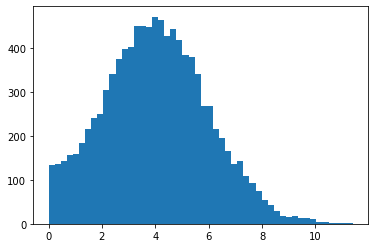

In [40]:
from pyro.infer.reparam.transform import TransformReparam
import pyro.distributions.constraints as constraints

# class PositiveFoldedNormal(dist.TransformedDistribution):
#     support = constraints.greater_than(0)
#     def __init__(self, loc, scale):
#         base_dist = dist.FoldedDistribution(dist.Normal(loc, scale))
#         transform = dist.transforms.AffineTransform(0., -1.)
#         super().__init__(base_dist, transform)

num_sales = 10000
scale = torch.tensor(0.2)

zzz = pyro.sample(
    "zzz",
    dist.FoldedDistribution(
        dist.Normal(loc=torch.tensor(4.0), scale=torch.tensor(2.0)).expand([num_sales,])
    ),
)
       
plt.hist(zzz.numpy(), bins=50)

In [19]:
print(X)
print(y)
y_gen = model(X,y)


      customer  item  list_price  salesperson  item_quality
0            0     0  173.554260            0      9.427942
1            0     1  142.062103            1      7.794953
2            0     2   29.493940            2      2.619012
3            0     3  153.875549            3      7.679921
4            0     4  212.421173            4      9.604979
...        ...   ...         ...          ...           ...
1847       191    46   74.849365           18      2.531097
1848       192    98  185.278244           12      7.923992
1849       192    26   52.207016            9      3.947307
1850       192    15  118.577347           19      6.166653
1851       192    23   64.158623            7      2.312023

[1852 rows x 5 columns]
      result       price
0          1   23.950771
1          1   18.224957
2          0         NaN
3          1   18.758598
4          0         NaN
...      ...         ...
1847       0         NaN
1848       0         NaN
1849       1   52.207016
1850 

In [43]:
torch.cat([y_gen[0], y_gen[1], y_gen[2]]).view(3, y_gen[1].size(0)).T

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [24]:
#df['pred_result'] = y_gen[0].numpy()
#df['pred_hidden_price'] = y_gen[1].numpy()
#df['pred_price'] = y_gen[2].numpy()

In [25]:
#df.iloc[:-10]

In [175]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['result', 'price'],axis=1), df[['result', 'price']], test_size=0.30, random_state=101)

In [ ]:
samples = mcmc.get_samples()
predictive=Predictive(model, samples, return_sites=("sales_wtp_bias_pct", "sales_wtp_uncertainty_pct", "beta_quality_loc", "beta_quality_scale", "result", "price_if_won"))
y_pred = predictive(X_test, None)

3000
3000
3000


RuntimeError: The size of tensor a (3000) must match the size of tensor b (7000) at non-singleton dimension 0
                 Trace Shapes:       
                  Param Sites:       
                 Sample Sites:       
              salespeople dist      |
                         value  100 |
       sales_wtp_bias_pct dist  100 |
                         value  100 |
sales_wtp_uncertainty_pct dist  100 |
                         value  100 |
         beta_quality_loc dist      |
                         value      |
       beta_quality_scale dist      |
                         value      |
                customers dist      |
                         value 3000 |
             beta_quality dist 3000 |
                         value 7000 |

In [141]:
pyro.distributions.Bernoulli(torch.tensor(1.0)).log_prob(torch.tensor(1.0))

tensor(-1.1921e-07)

In [82]:
pyro.distributions.Bernoulli(torch.tensor(0.0)).sample([10])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [153]:
t = torch.tensor(y.sample(10).result.values)
print(t, torch.tensor(1))
s = t==torch.tensor(1)
s.type(torch.ByteTensor)

tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0]) tensor(1)


tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [53]:
X.describe()

,item,list_price,salesperson
count,20000.000000,20000.000000,20000.000000
mean,49.545100,110.767687,99.164200
std,28.953214,54.031694,57.461878
min,0.000000,20.000000,0.000000
25%,24.000000,67.288254,49.000000
50%,50.000000,108.046806,99.000000
75%,75.000000,158.223373,148.000000
max,99.000000,213.749908,199.000000
